In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv("Data/Surfactant_fix", index_col = "Experiment")
df.head()

,Number_cyclic,Soaking_time,Injection_rate,Surf_Concentration,Mole_weight,Surfactant_vol,Production_rate,Recovery_factor
Experiment,,,,,,,,
1,1,3.0,2500,0.03,375,0.0055,500,18.984
2,1,3.0,2500,0.03,250,0.0010,500,18.982
3,1,3.0,2500,0.03,375,0.0055,1000,18.972
4,1,3.0,2500,0.03,375,0.0100,750,19.135
5,1,3.0,2500,0.03,500,0.0100,500,18.986


# Data Processing

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

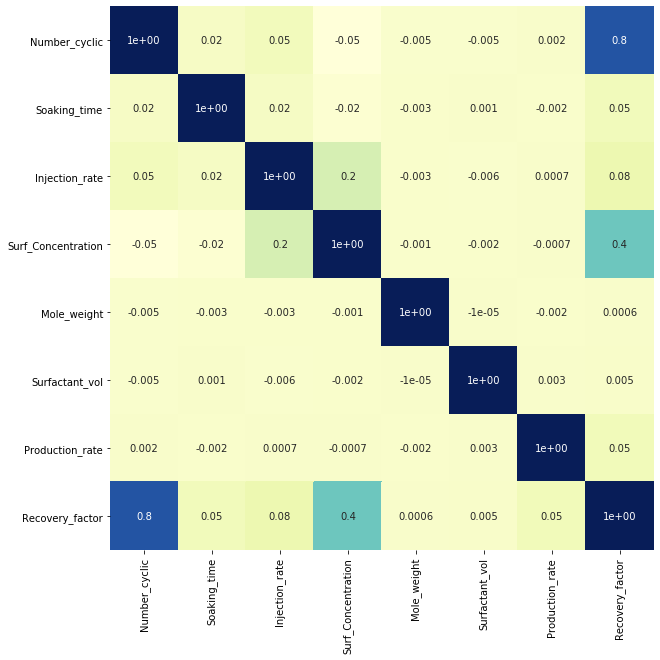

In [6]:
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr(), cmap= "YlGnBu", cbar= False, annot= True, square= True, fmt= '.1')
plt.savefig('Picture/corrplot_600dpi.png', dpi = 600)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number_cyclic,1980.0,1.966667,0.820961,1.000,1.000,2.0000,3.00000,3.000
Soaking_time,1980.0,16.268182,10.989581,3.000,3.000,16.5000,30.00000,30.000
Injection_rate,1980.0,2273.484848,198.093432,2000.000,2000.000,2250.0000,2500.00000,2500.000
Surf_Concentration,1980.0,0.152045,0.106938,0.030,0.030,0.1650,0.30000,0.300
Mole_weight,1980.0,374.431818,102.124937,250.000,250.000,375.0000,500.00000,500.000
Surfactant_vol,1980.0,0.005491,0.003668,0.001,0.001,0.0055,0.01000,0.010
Production_rate,1980.0,750.126263,204.252997,500.000,500.000,750.0000,1000.00000,1000.000
Recovery_factor,1980.0,20.379424,1.502604,17.799,19.045,20.1620,21.15775,27.079


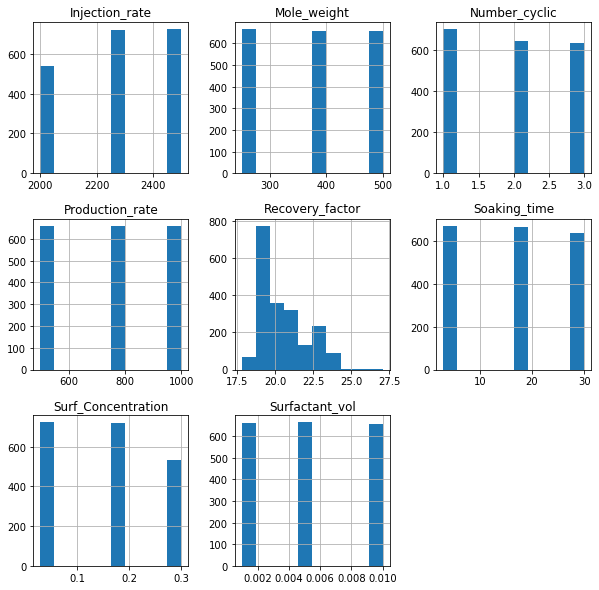

In [5]:
df.hist(figsize=(10, 10))
plt.savefig('Picture/Histogram_data_600dpi', dpi = 300)

## Normalization

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit (df)
df_norm = scaler.transform(df)

In [9]:
df_norm

array([[0.        , 0.        , 1.        , ..., 0.5       , 0.        ,
        0.12769397],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.12747845],
       [0.        , 0.        , 1.        , ..., 0.5       , 1.        ,
        0.12640086],
       ...,
       [0.        , 0.5       , 0.        , ..., 1.        , 0.        ,
        0.12877155],
       [0.        , 1.        , 0.        , ..., 1.        , 0.5       ,
        0.13469828],
       [0.        , 1.        , 0.        , ..., 0.5       , 0.5       ,
        0.13706897]])

# Machine Learning Modelling

In [7]:
df.columns

Index(['Number_cyclic', 'Soaking_time', 'Injection_rate', 'Surf_Concentration',
       'Mole_weight', 'Surfactant_vol', 'Production_rate', 'Recovery_factor'],
      dtype='object')

In [8]:
df1 = df.drop(columns = (['Mole_weight', 'Surfactant_vol', 'Production_rate']))
df1.head()

,Number_cyclic,Soaking_time,Injection_rate,Surf_Concentration,Recovery_factor
Experiment,,,,,
1,1,3.0,2500,0.03,18.984
2,1,3.0,2500,0.03,18.982
3,1,3.0,2500,0.03,18.972
4,1,3.0,2500,0.03,19.135
5,1,3.0,2500,0.03,18.986


In [9]:
X = df.drop(columns="Recovery_factor")
y = df.Recovery_factor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1584, 7), (396, 7), (1584,), (396,))

In [10]:
X.columns

Index(['Number_cyclic', 'Soaking_time', 'Injection_rate', 'Surf_Concentration',
       'Mole_weight', 'Surfactant_vol', 'Production_rate'],
      dtype='object')

# Random Forest

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax', poly = 1), X.columns )])


from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50,  n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 63, 'algo__max_features': 0.9446974381141753, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 163}
0.9822455645487816 0.9572578965919681 0.9770951946950689


In [13]:
y_true = y_test
y_pred = model_RF.predict(X_test)

In [14]:
mean_squared_error(y_true, y_pred)

0.05467173414156438

In [15]:
from jcopml.feature_importance import mean_loss_decrease, mean_score_decrease

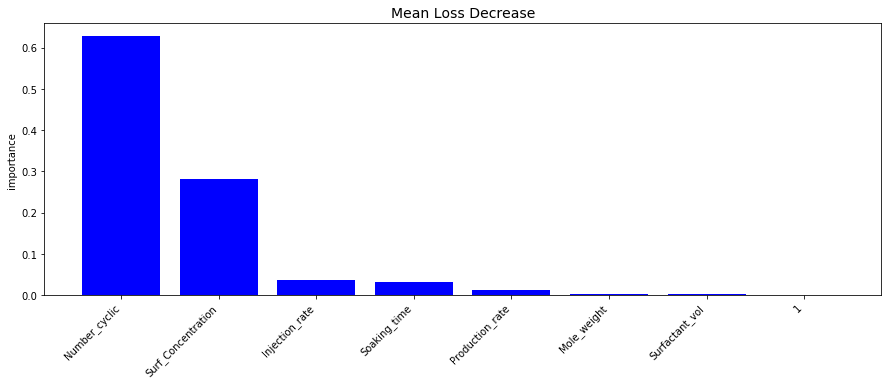

In [16]:
df_imp = mean_loss_decrease(X_train, model_RF, plot=True)
plt.savefig('Mean_loss_decrease_600dpi.png', dpi = 300)

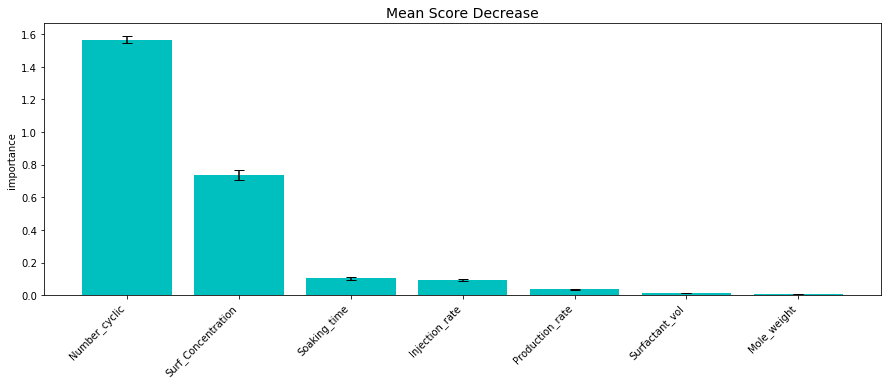

In [17]:
mean_score_decrease(X_train, y_train, model_RF, plot = True, topk = None)
plt.savefig('Mean_score_decrease_600dpi.png', dpi = 300)

In [18]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
import matplotlib.pyplot as plt

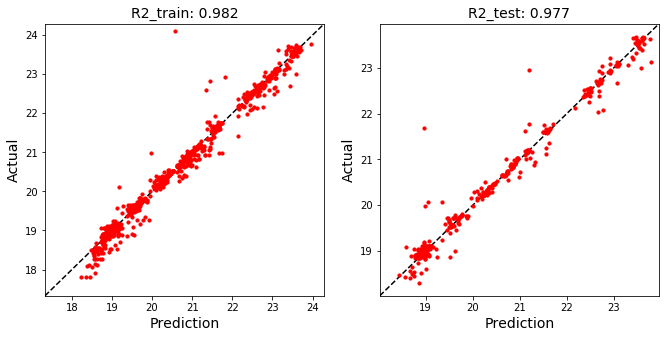

In [19]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_RF)
plt.savefig('ActVSPred_RF_600dpi.png', dpi = 300)

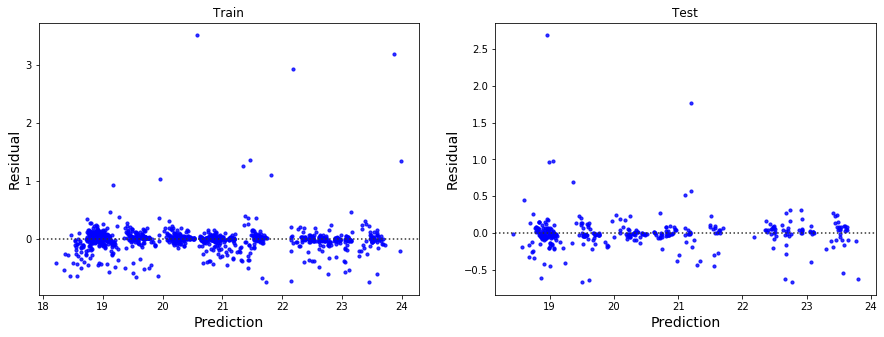

In [20]:
plot_residual(X_train, y_train, X_test, y_test, model_RF)

# KNN

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from sklearn.neighbors import KNeighborsRegressor

In [28]:
rsp.knn_params

{'algo__n_neighbors': Integer(low=1, high=40),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': Real(low=1, high=2, prior='uniform')}

In [29]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsRegressor())
])

model_KNN = RandomizedSearchCV(pipeline, rsp.knn_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_KNN.fit(X_train, y_train)

print(model_KNN.best_params_)
print(model_KNN.score(X_train, y_train), model_KNN.best_score_, model_KNN.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__n_neighbors': 6, 'algo__p': 1.4565345704829102, 'algo__weights': 'distance'}
1.0 0.8705759261533726 0.923575408343958


In [30]:
from jcopml.plot import plot_actual_vs_prediction, plot_residual
import matplotlib.pyplot as plt

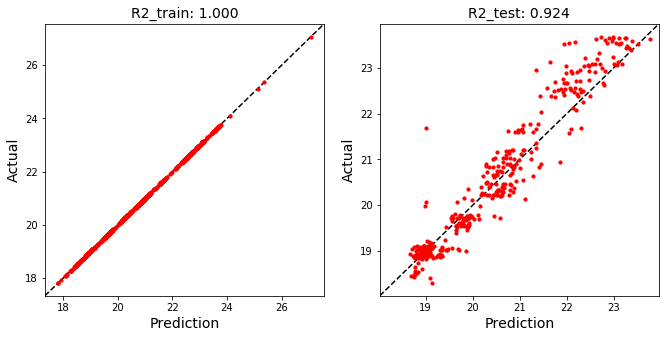

In [31]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_KNN)
plt.savefig('ActVSPred_KNN_600dpi.png', dpi = 300)

# XGBOOST

In [32]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}

In [34]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly = 2), X.columns )])


from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model_XGB = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGB.fit(X_train, y_train)

print(model_XGB.best_params_)
print(model_XGB.score(X_train, y_train), model_XGB.best_score_, model_XGB.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7419203085006956, 'algo__gamma': 1, 'algo__learning_rate': 0.27762530094438326, 'algo__max_depth': 7, 'algo__n_estimators': 113, 'algo__reg_alpha': 0.09444574254983565, 'algo__reg_lambda': 0.12329098365270522, 'algo__subsample': 0.5137705091792748}
0.9735089440428474 0.948680368920796 0.9684534156889173


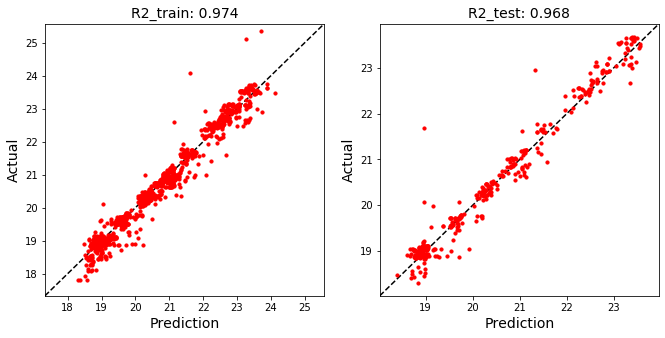

In [35]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_XGB)
plt.savefig('ActVSPred_XGB2_600dpi.png', dpi = 300)

# ANN

In [36]:
from sklearn.neural_network import MLPRegressor

In [37]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly = 3), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=42))
])

parameter = {
    "mlp__alpha": [0.0001, 0.0003, 0.001, 0.003],
    "mlp__hidden_layer_sizes": [(16, 8, 4), (16, 4), (8, 4)],
    "mlp__learning_rate_init": [0.001, 0.005, 0.01],
    "mlp__activation": ["identity"]
}

model_ANN = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_ANN.fit(X_train, y_train)

print(model_ANN.best_params_)
print(model_ANN.score(X_train, y_train), model_ANN.best_score_, model_ANN.score(X_test, y_test))

C:\ProgramData\Miniconda3\envs\env_jcopdl\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (16, 4), 'mlp__alpha': 0.003, 'mlp__activation': 'identity'}
0.8612965043665295 0.8418382926287502 0.8903394125032162


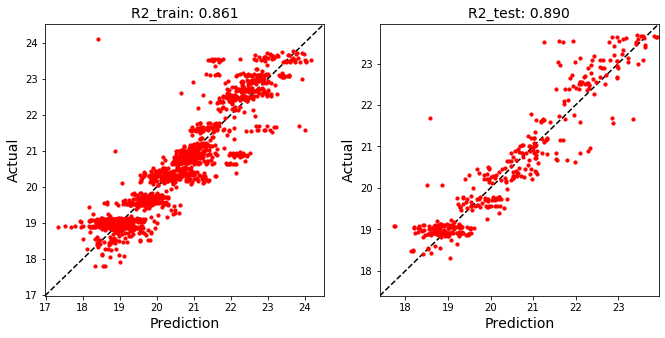

In [38]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_ANN)
plt.savefig('ActVSPred_ANN_600dpi.png', dpi = 300)

# SVM

In [39]:
from sklearn.svm import SVR

In [40]:
rsp.svm_params

{'algo__gamma': Real(low=-3, high=3, prior='log-uniform'),
 'algo__C': Real(low=-3, high=3, prior='log-uniform')}

In [41]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), X.columns )])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])


model_SVM = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM.fit(X_train, y_train)

print(model_SVM.best_params_)
print(model_SVM.score(X_train, y_train), model_SVM.best_score_, model_SVM.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\ProgramData\Miniconda3\envs\env_jcopdl\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 36.70373762529395, 'algo__gamma': 2.331649063896066}
0.9801175501848604 0.9097893853589619 0.9438092778687921


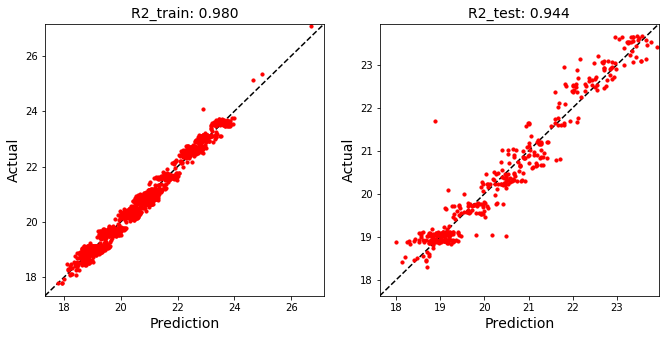

In [42]:
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model_SVM)
plt.savefig('ActVSPred_SVM_600dpi.png', dpi = 300)